In [1]:
import os
import re
import sys
import json
import nrrd
import time
import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d import Axes3D

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.core.reference_space import ReferenceSpace

In [5]:
%matplotlib notebook

In [6]:
areas_of_interest = {
    'MO': [
        'MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b',
        'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'
    ],
#     'ACA': [
#         'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
#         'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b'
#     ],
    'SS': [
        'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b',
        'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b',
        'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b'
    ],
    'VIS': [
        'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',
        'VISam1', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b',
        'VISpm1', 'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b',
        'VISrl1', 'VISrl2/3', 'VISrl4', 'VISrl5', 'VISrl6a', 'VISrl6b',
    ],
#     'MO-TH': [
#         'AV', 'CL', 'MD', 'PO', 'RT', 'VAL', 'VPL', 'VPM', 'VM'
#     ],
}

### Load the CCF

In [7]:
# The manifest file is a simple JSON file that keeps track of all of
# the data that has already been downloaded onto the hard drives.
# If you supply a relative path, it is assumed to be relative to your
# current working directory.
mcc = MouseConnectivityCache(resolution=10)
structure_tree = mcc.get_structure_tree()
mmpix = 0.010 # mm, we are using CCF with 10 um resolution
template, template_info = mcc.get_template_volume()
annot, annot_info = mcc.get_annotation_volume()

In [8]:
annot.shape

(1320, 800, 1140)

### Load the laplacian

"streamlines" is an array the same shape as the CCF (AP, DV, ML) containing float values for all cortical areas representing the depth in the cortex: 0=surface, 1=bottom of cortex (and 0 everywhere else).
<br>"header" is an OrderedDict, with info about "streamlines"?

In [9]:
streamlines, header = nrrd.read(r"C:\Users\lesliec\code\EEG_analysis\laplacian_10.nrrd")

In [10]:
streamlines.shape

(1320, 800, 1140)

### Plot some stuff

<IPython.core.display.Javascript object>


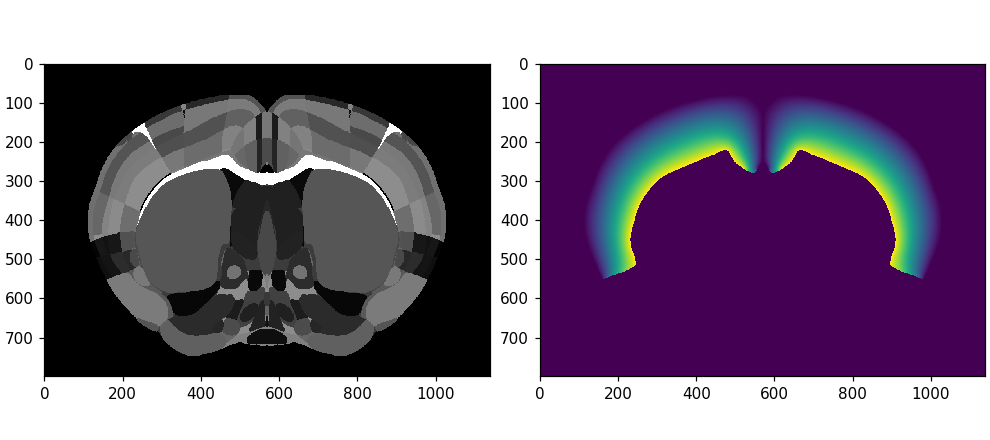

In [11]:
AP = 500
fig, axs = plt.subplots(1, 2, figsize=(9, 4), constrained_layout=True)
axs[0].imshow(annot[AP,:,:], cmap='gray', aspect='equal', vmin=0, vmax=2000, interpolation='none')
axs[1].imshow(streamlines[AP,:,:], interpolation='none')

### Look at probes from one experiment

In [12]:
rec_folder = r'F:\EEG_exp\mouse586466\estim_vis_2021-07-29_10-37-41\experiment1\recording1' # has 10um CCF
exp = EEGexp(rec_folder, preprocess=False, make_stim_csv=False)

Experiment type: electrical and sensory stimulation


In [13]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
print(probe_list)

['probeB', 'probeC', 'probeF']


In [14]:
area_info = {key: {} for key in list(areas_of_interest.keys())}
for probei in probe_list:
    print(probei)
    with open(exp.ephys_params[probei]['probe_info']) as data_file:
        data = json.load(data_file)
    npx_allch = np.array(data['channel']) # this is an array from 0 to 384
    surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
    allch_z = np.array(data['vertical_pos']) # vert position of each ch (um), rel to the tip (ch 0 is 20 um from tip)
    all_ch_depths = allch_z[surface_ch] - allch_z
    
    if 'area_ch' in data.keys():
        ch_areas = np.array(data['area_ch'])
        ch_CCF_coords = np.array(data['ccf_coord_ch'])
        parent_areas = [k for x in np.unique(ch_areas) for k in list(areas_of_interest.keys()) if x in areas_of_interest[k]]
        for ctxarea in np.unique(parent_areas):
            print(' {}'.format(ctxarea))
            parent_chs = np.array([x for x in npx_allch if ch_areas[x] in areas_of_interest[ctxarea]])
            if len(parent_chs) > 10:
                stline = []
                for chi in parent_chs:
                    stline.append(streamlines[ch_CCF_coords[chi][0], ch_CCF_coords[chi][1], ch_CCF_coords[chi][2]])
                area_info[ctxarea]['SLdepth'] = np.array(stline)
                area_info[ctxarea]['npxchs'] = parent_chs
                area_info[ctxarea]['depth'] = all_ch_depths[parent_chs]
                area_info[ctxarea]['CCF_coords'] = ch_CCF_coords[parent_chs]
            else:
                print('  not enough chs in parent area.')     
    else:
        print('{} does not have area assignments.'.format(probei))

probeB
 SS
probeC
probeC does not have area assignments.
probeF
 MO


<IPython.core.display.Javascript object>


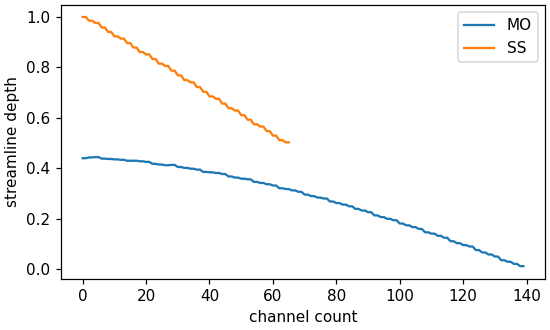

MO: gradient=0.0031, 0.4285 depth
 Distance: 117.4 pixels, 140 chs, 1.677 pix/ch
SS: gradient=0.0077, 0.4974 depth
 Distance: 55.0 pixels, 66 chs, 1.667 pix/ch


Text(0.5, 0, 'channel count')

In [16]:
fig, ax = plt.subplots(figsize=(5,3), constrained_layout=True)

for areax, infox in area_info.items():
    if 'SLdepth' not in infox.keys():
        continue
    ax.plot(infox['SLdepth'], label=areax)
    meangrad = np.mean(np.diff(infox['SLdepth'][::-1]))
    deltadepth = infox['SLdepth'][0] - infox['SLdepth'][-1]
    distance = np.linalg.norm(area_info[areax]['CCF_coords'][0,:] - area_info[areax]['CCF_coords'][-1,:])
    num_chs = len(area_info[areax]['npxchs'])
    print('{}: gradient={:.4f}, {:.4f} depth'.format(areax, meangrad, deltadepth))
    print(' Distance: {:.1f} pixels, {:d} chs, {:.3f} pix/ch'.format(distance, num_chs, distance / (num_chs/2)))
ax.legend()
ax.set_ylabel('streamline depth')
ax.set_xlabel('channel count')

### Can we define a plane tangent to the brain surface near the probe

In [36]:
deltapixel = 25
testarea = 'SS'

## Get probe direction vector ##
probe_vec = area_info[testarea]['CCF_coords'][0,:] - area_info[testarea]['CCF_coords'][-1,:]
unit_probe_vec = probe_vec / np.linalg.norm(probe_vec)
print(unit_probe_vec)

## Define insertion point ##
surfcoords = area_info[testarea]['CCF_coords'][np.argmin(area_info[testarea]['depth']),:]

## Define 3 points surrounding insertion ##
points = [
    surfcoords + [-deltapixel, 0, 0], # moves anterior by deltapixel
    surfcoords + [deltapixel, 0, 0], # moves posterior by deltapixel
    surfcoords + [0, 0, deltapixel], # moves medial by deltapixel
]

## Now find surface level ##
for i, icoords in enumerate(points):
    points[i][1] = np.nonzero(annot[icoords[0], :, icoords[2]])[0][0]

## Use 3 points to define plane tangent(?) to surface ##
p0, p1, p2 = points
x0, y0, z0 = p0
x1, y1, z1 = p1
x2, y2, z2 = p2

ux, uy, uz = u = [x1-x0, y1-y0, z1-z0]
vx, vy, vz = v = [x2-x0, y2-y0, z2-z0]

u_cross_v = [uy*vz-uz*vy, uz*vx-ux*vz, ux*vy-uy*vx]

surf_normal = -np.array(u_cross_v)
surf_unit_normal = surf_normal / np.linalg.norm(surf_normal)
print(surf_unit_normal)

## Degrees between ##
probe_angle = np.degrees(np.arccos(np.dot(unit_probe_vec, surf_unit_normal)))
print('{}: {:.1f} degrees from parallel'.format(testarea, probe_angle))

[0.         0.99983475 0.01817881]
[0.19551547 0.97757736 0.07820619]
SS: 11.8 degrees from parallel


#### Try to plot on CCF annot

In [37]:
tipcoords = area_info[testarea]['CCF_coords'][np.argmax(area_info[testarea]['depth']),:]
print(tipcoords)

surfnormtip = (surfcoords + 150 * surf_unit_normal).astype(int)

[649 153 457]


<IPython.core.display.Javascript object>


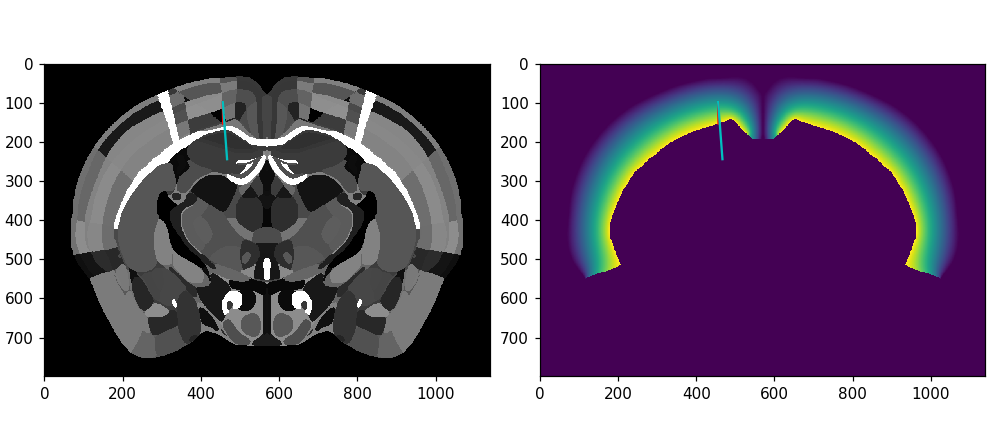

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4), constrained_layout=True)

axs[0].imshow(annot[surfcoords[0],:,:], cmap='gray', aspect='equal', vmin=0, vmax=2000, interpolation='none')
axs[1].imshow(streamlines[surfcoords[0],:,:], interpolation='none')

axs[0].plot([surfcoords[2], tipcoords[2]], [surfcoords[1], tipcoords[1]], color='r')
axs[1].plot([surfcoords[2], tipcoords[2]], [surfcoords[1], tipcoords[1]], color='r')

axs[0].plot([surfcoords[2], surfnormtip[2]], [surfcoords[1], surfnormtip[1]], color='c')
axs[1].plot([surfcoords[2], surfnormtip[2]], [surfcoords[1], surfnormtip[1]], color='c')

### Get slice of CCF along probe insertion line

In [46]:
## get vector between the surface and tip, points from surface to tip ##
probe_vec = area_info[areax]['CCF_coords'][0,:] - area_info[areax]['CCF_coords'][-1,:]
print(probe_vec)

## get the norm and the direction vector ##
norm = np.linalg.norm(probe_vec)
print(norm)
direction = probe_vec / norm # unit vector
print(direction)

[-21  90  19]
94.35041070392857
[-0.22257455  0.95389092  0.20137697]


In [17]:
annot.shape

(1320, 800, 1140)

In [18]:
area_info[areax]['CCF_coords'][0,:]

array([865, 162, 308])

In [19]:
area_info[areax]['CCF_coords'][-1,:]

array([886,  72, 289])

In [20]:
points = [
    area_info[areax]['CCF_coords'][0,:],
    area_info[areax]['CCF_coords'][-1,:],
    area_info[areax]['CCF_coords'][0,:] + [0,300,0],
]
p0, p1, p2 = points
x0, y0, z0 = p0
x1, y1, z1 = p1
x2, y2, z2 = p2

ux, uy, uz = u = [x1-x0, y1-y0, z1-z0]
vx, vy, vz = v = [x2-x0, y2-y0, z2-z0]

u_cross_v = [uy*vz-uz*vy, uz*vx-ux*vz, ux*vy-uy*vx]

point  = np.array(p0)
normal = np.array(u_cross_v)
d = -point.dot(normal)

xx, yy = np.meshgrid(range(annot.shape[0]), range(annot.shape[1]), indexing='ij')
z = (-normal[0] * xx - normal[1] * yy - d) * 1. / normal[2]

In [21]:
CCFslice = np.zeros_like(xx)
SLslice = np.zeros(xx.shape, dtype=float)
for i in range(annot.shape[0]):
    for j in range(annot.shape[1]):
        if z[i,j] > 0:
            CCFslice[i,j] = annot[i, j, int(z[i,j])]
            SLslice[i,j] = streamlines[i, j, int(z[i,j])]

<IPython.core.display.Javascript object>


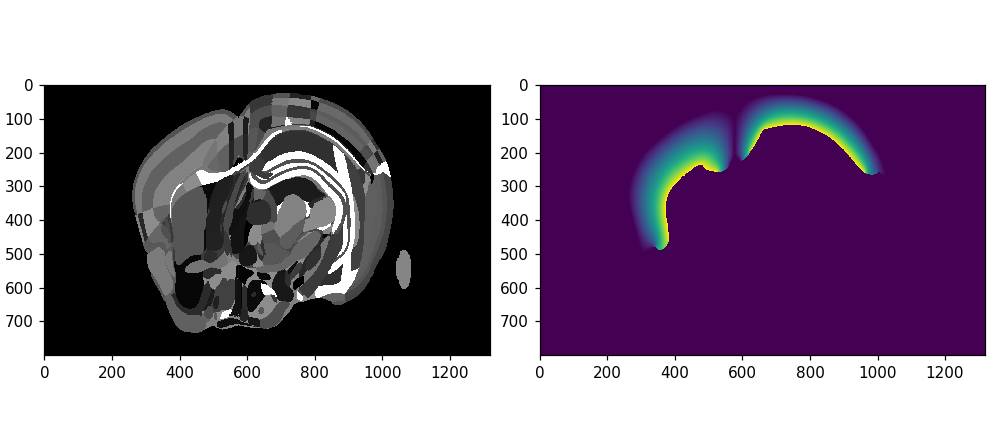

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4), constrained_layout=True)
axs[0].imshow(CCFslice.T, cmap='gray', aspect='equal', vmin=0, vmax=2000, interpolation='none')
axs[1].imshow(SLslice.T, interpolation='none')

#### Plot probe surface and tip on template volume.

<IPython.core.display.Javascript object>


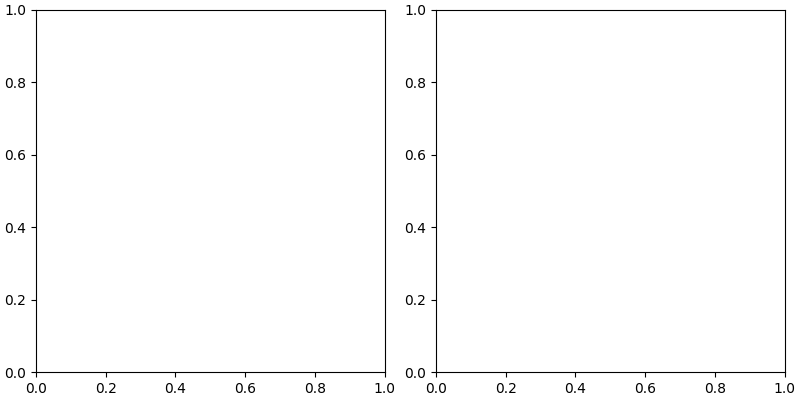

KeyError: 'stim'

In [18]:
plot_probe = 'stim'

fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

# surface #
surface_coords = probe_info[plot_probe]['ch_CCF_coords'][probe_info[plot_probe]['surface_channel']]
axs[0].imshow(template[surface_coords[0],:,:], cmap='gray', aspect='equal', vmin=template.min(), vmax=template.max())
axs[0].scatter(surface_coords[2], surface_coords[1], s=20, c='r')
axs[0].set_title('surface: {}'.format(probe_info[plot_probe]['ch_areas'][probe_info[plot_probe]['surface_channel']]))

# tip #
tip_coords = probe_info[plot_probe]['ch_CCF_coords'][0]
axs[1].imshow(template[tip_coords[0],:,:], cmap='gray', aspect='equal', vmin=template.min(), vmax=template.max())
axs[1].scatter(tip_coords[2], tip_coords[1], s=20, c='r')
axs[1].set_title('tip: {}'.format(probe_info[plot_probe]['ch_areas'][0]))

plt.suptitle(plot_probe)

#### Plot stim electrode surface and tip

In [19]:
estim_surf_area = structure_tree.get_structures_by_id(
    [annot[stim_elec_coords[0,0],stim_elec_coords[0,1],stim_elec_coords[0,2]]])[0]['acronym']
estim_tip_area = structure_tree.get_structures_by_id(
    [annot[stim_elec_coords[1,0],stim_elec_coords[1,1],stim_elec_coords[1,2]]])[0]['acronym']

<IPython.core.display.Javascript object>


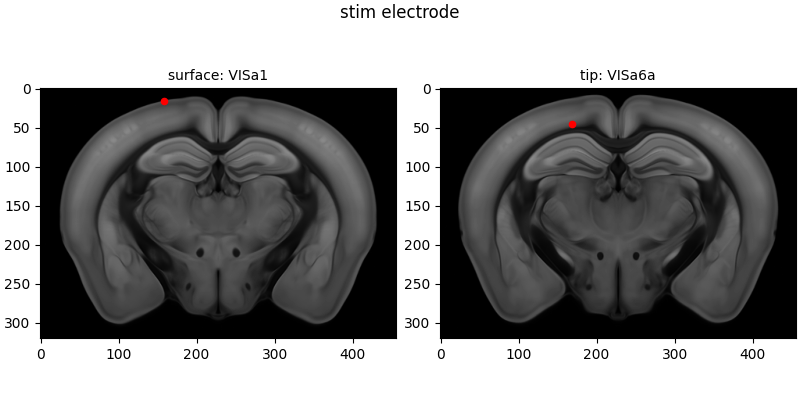

Text(0.5, 0.98, 'stim electrode')

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

# surface #
axs[0].imshow(template[stim_elec_coords[0, 0],:,:], cmap='gray', aspect='equal', vmin=template.min(), vmax=template.max())
axs[0].scatter(stim_elec_coords[0, 2], stim_elec_coords[0, 1], s=20, c='r')
axs[0].set_title('surface: {}'.format(estim_surf_area))

# tip #
axs[1].imshow(template[stim_elec_coords[1, 0],:,:], cmap='gray', aspect='equal', vmin=template.min(), vmax=template.max())
axs[1].scatter(stim_elec_coords[1, 2], stim_elec_coords[1, 1], s=20, c='r')
axs[1].set_title('tip: {}'.format(estim_tip_area))

plt.suptitle('stim electrode')

<IPython.core.display.Javascript object>


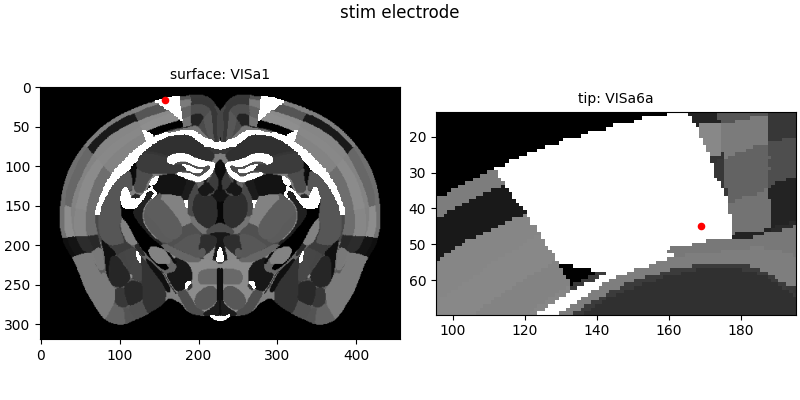

Text(0.5, 0.98, 'stim electrode')

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

# surface #
axs[0].imshow(annot[stim_elec_coords[0, 0],:,:], cmap='gray', aspect='equal', vmin=0, vmax=2000)
axs[0].scatter(stim_elec_coords[0, 2], stim_elec_coords[0, 1], s=20, c='r')
axs[0].set_title('surface: {}'.format(estim_surf_area))

# tip #
axs[1].imshow(annot[stim_elec_coords[1, 0],:,:], cmap='gray', aspect='equal', vmin=0, vmax=2000)
axs[1].scatter(stim_elec_coords[1, 2], stim_elec_coords[1, 1], s=20, c='r')
axs[1].set_title('tip: {}'.format(estim_tip_area))

plt.suptitle('stim electrode')

In [32]:
structure_tree.get_structures_by_id([9])[0]['acronym']

'SSp-tr6a'

In [15]:
len_stim_elec = np.linalg.norm(stim_elec_coords[0,:] - stim_elec_coords[1,:]) * mmpix
print('Length of stim electrode in brain: {:.2f} mm'.format(len_stim_elec)) # this is in mm now

Length of stim electrode in brain: 1.51 mm


In [16]:
print(stim_elec_coords[0,:])
print(stim_elec_coords[1,:])

[369 134 419]
[415 272 461]


Some linear algebra:

In [24]:
## get vector between the stim electrode surface and tip, points from surface to tip ##
stim_elec_vec = stim_elec_coords[1,:] - stim_elec_coords[0,:]
print(stim_elec_vec)

## get the norm and the direction vector ##
norm = np.linalg.norm(stim_elec_vec)
print(norm)
direction = stim_elec_vec / norm # unit vector
print(direction)

[13 29 11]
33.63034344160047
[0.38655567 0.8623165  0.32708557]


In [25]:
other_coords = (stim_elec_coords[1,:] - (0.3/mmpix) * direction).astype(int)
print(other_coords)
other_tip_area = structure_tree.get_structures_by_id(
    [annot[other_coords[0],other_coords[1],other_coords[2]]])[0]['acronym']

[282  34 165]


<IPython.core.display.Javascript object>


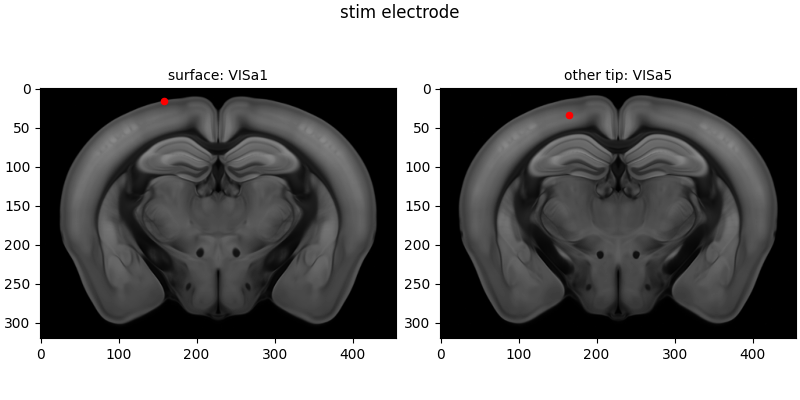

Text(0.5, 0.98, 'stim electrode')

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

# surface #
axs[0].imshow(template[stim_elec_coords[0, 0],:,:], cmap='gray', aspect='equal', vmin=template.min(), vmax=template.max())
axs[0].scatter(stim_elec_coords[0, 2], stim_elec_coords[0, 1], s=20, c='r')
axs[0].set_title('surface: {}'.format(estim_surf_area))

# other tip #
axs[1].imshow(template[other_coords[0],:,:], cmap='gray', aspect='equal', vmin=template.min(), vmax=template.max())
axs[1].scatter(other_coords[2], other_coords[1], s=20, c='r')
axs[1].set_title('other tip: {}'.format(other_tip_area))

plt.suptitle('stim electrode')

In [27]:
len_stim_elec = np.linalg.norm(stim_elec_coords[0,:] - other_coords) * mmpix
print('Length of stim electrode in brain: {:.2f} mm'.format(len_stim_elec)) # this is in mm now

Length of stim electrode in brain: 0.52 mm


<IPython.core.display.Javascript object>


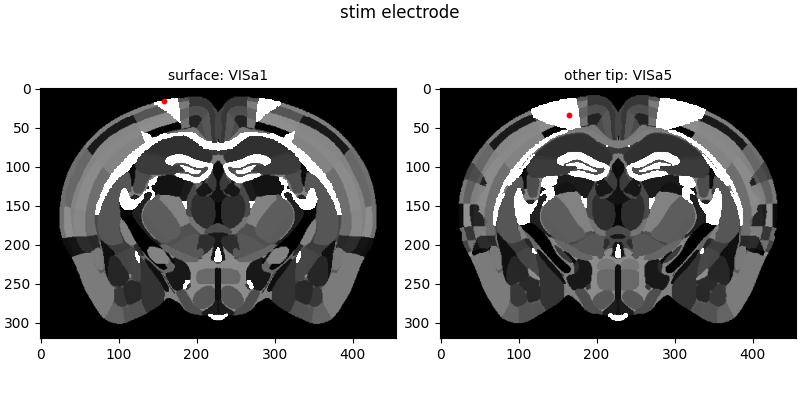

Text(0.5, 0.98, 'stim electrode')

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

# surface #
axs[0].imshow(annot[stim_elec_coords[0, 0],:,:], cmap='gray', aspect='equal', vmin=0, vmax=2000)
axs[0].scatter(stim_elec_coords[0, 2], stim_elec_coords[0, 1], s=10, c='r')
axs[0].set_title('surface: {}'.format(estim_surf_area))

# other tip #
axs[1].imshow(annot[other_coords[0],:,:], cmap='gray', aspect='equal', vmin=0, vmax=2000)
axs[1].scatter(other_coords[2], other_coords[1], s=10, c='r')
axs[1].set_title('other tip: {}'.format(other_tip_area))

plt.suptitle('stim electrode')

#### Need to reflect stim electrode from right to left hemi

In each of these multi-dimensional arrays, the 0th dimension refers to AP, the 1st dimension refers to DV, and the 2nd dimension refers to ML. In other words: (AP_dim, DV_dim, ML_dim).

# To look at multiple experiments

#### To print a list of areas for each probe

In [11]:
sub_dirs = {
    '590480a': r'T:\zap-n-zip\EEG_exp\mouse590480\estim_vis_2021-11-11_10-54-19\experiment1\recording1',
    '590480b': r'T:\zap-n-zip\EEG_exp\mouse590480\urethane_vis_2021-11-12_11-14-43\experiment1\recording1',
    '590481a': r'T:\zap-n-zip\EEG_exp\mouse590481\estim_vis_2021-11-18_10-52-12\experiment1\recording1',
    '590481b': r'T:\zap-n-zip\EEG_exp\mouse590481\urethane_vis_2021-11-19_10-59-04\experiment1\recording1',
    '599017a': r'T:\zap-n-zip\EEG_exp\mouse599017\estim_vis_2022-02-10_10-53-32\experiment1\recording1',
    '599017b': r'T:\zap-n-zip\EEG_exp\mouse599017\urethane_vis_2022-02-11_11-12-13\experiment1\recording1',
    '599975a': r'T:\zap-n-zip\EEG_exp\mouse599975\estim_vis_2022-03-31_12-03-06\experiment1\recording1',
    '599975b': r'T:\zap-n-zip\EEG_exp\mouse599975\urethane_vis_2022-04-01_10-58-41\experiment1\recording1',
    '618552a': r'T:\zap-n-zip\EEG_exp\mouse618552\estim_vis_2022-04-26_11-14-11\experiment1\recording1',
    '618552b': r'T:\zap-n-zip\EEG_exp\mouse618552\urethane_vis_2022-04-27_10-33-32\experiment1\recording1',
}
sub_exp = {}
for mousei, recdiri in sub_dirs.items():
    sub_exp[mousei] = EEGexp(recdiri, preprocess=False, make_stim_csv=False)

Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation


In [12]:
for mousei, expi in sub_exp.items():
    exp_tag = expi.experiment_folder[expi.experiment_folder.find('mouse')+12:expi.experiment_folder.find(str(expi.date.year))-1]
    print('{} - {}'.format(mousei, exp_tag))
    
    ### Load unit data ###
    probe_list = [x.replace('_sorted', '') for x in expi.experiment_data if 'probe' in x]
    for probei in probe_list:
        ## Load probe_info.json ##
        with open(expi.ephys_params[probei]['probe_info']) as data_file:
            data = json.load(data_file)
        npx_allch = np.array(data['channel']) # this is an array from 0 to 384
        surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
        allch_z = np.array(data['vertical_pos']) # vertical position of each electrode (um), relative to the tip (ch 0 is 20 um from tip)
        ref_mask = np.array(data['mask']) # contains a False for Npx reference channels

        ## Get all brain ch areas ##
        npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch])
        if 'area_ch' in data.keys():
            ch_areas = np.array(data['area_ch'])[npx_chs]
            pr_area_list = np.unique(ch_areas)
            print(' {}: '.format(probei) + ', '.join(map(str, pr_area_list)))
        else:
            print('  NO area assignments.')
    print('')

590480a - estim_vis
 probeB: AV, CA1, CA2, CA3, LD, SSp-tr2/3, SSp-tr4, SSp-tr5, SSp-tr6a, SSp-tr6b, VAL, VISa1, VISa2/3, alv, ccb, cing, root
 probeC: DG-mo, DG-po, DG-sg, LP, PoT, ProS, SGN, VISp1, VISp2/3, VISp4, VISp5, VISp6a, VISp6b, alv, bsc, fiber tracts, fp, null, or
 probeF: ACAd5, ACAv1, DP, ILA1, LSr, MOs1, MOs2/3, MOs5, PL1, PL2/3, PL5, STR, TTd, null

590480b - urethane_vis
 probeB: CA1, CA2, CA3, LD, SSp-tr2/3, SSp-tr4, SSp-tr5, SSp-tr6a, SSp-tr6b, VAL, VISa1, VISa2/3, alv, ccb, cing, null, root
 probeF: ACAd5, ACAv1, DP, ILA1, ILA2/3, ILA5, LSr, MOs1, MOs2/3, MOs5, OLF, PL5, STR, TTd, root

590481a - estim_vis
 probeB: AD, AV, CA1, CA2, CA3, IAD, MOp6a, MOp6b, RSPagl1, RSPagl2/3, RSPagl5, RSPagl6a, alv, ccb, cing, null, root
 probeC: CA1, DG-mo, DG-po, DG-sg, LP, PoT, SGN, VISp1, VISp2/3, VISp4, VISp5, VISp6a, VISp6b, alv, bsc, fiber tracts, fp, null, or
 probeF: ACAd5, ACAv1, ACAv2/3, ACB, DP, ILA1, LSr, MOs1, MOs2/3, MOs5, PL1, PL2/3, PL5, STR, TTd, null

590481b - ure

#### To find average cortical chs across mice

In [7]:
sub_dirs = {
    '569069a': r'F:\EEG_exp\mouse569069\estim_vis1_2021-03-11_11-02-08\experiment1\recording1',
    '569069b': r'F:\EEG_exp\mouse569069\estim_vis2_2021-03-12_10-52-44\experiment1\recording1',
    '569072': r'F:\EEG_exp\mouse569072\estim_vis_2021-04-22_10-26-58\experiment1\recording1',
    '569073a': r'F:\EEG_exp\mouse569073\estim_vis_2021-04-15_10-27-22\experiment1\recording1',
    '569073b': r'F:\EEG_exp\mouse569073\estim_2021-04-16_10-42-44\experiment1\recording1',
    '571619a': r'F:\EEG_exp\mouse571619\estim1_2021-03-18_11-41-26\experiment1\recording1',
    '571619b': r'F:\EEG_exp\mouse571619\estim2_2021-03-19_10-09-01\experiment1\recording1',
#     '571618': r'F:\EEG_exp\mouse571618\estim1_2021-04-29_12-28-54\experiment1\recording1',
}

In [9]:
sub_ctx_chs = {}
for mousei, recdiri in sub_dirs.items():
    print(mousei)
    sub_ctx_chs[mousei] = {}
    expi = EEGexp(recdiri, preprocess=False, make_stim_csv=False)
    probe_list = [x.replace('_sorted', '') for x in expi.experiment_data if 'probe' in x]
    
    for probei in probe_list:
        print(' {}'.format(probei))
        sub_ctx_chs[mousei][probei] = {}
        ## Load probe_info.json ##
        with open(expi.ephys_params[probei]['probe_info']) as data_file:
            data = json.load(data_file)
        npx_allch = np.array(data['channel']) # this is an array from 0 to 384
        surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
        allch_z = np.array(data['vertical_pos']) # vert pos of each electrode (um), rel to the tip (ch 0 is 20 um from tip)
        ref_mask = np.array(data['mask']) # contains a False for Npx reference channels

        ## Get all ch depths ##
        npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch]) 
        all_ch_depths = allch_z[surface_ch] - allch_z

        if 'area_ch' in data.keys():
            ch_areas = np.array(data['area_ch'])
            ## determine cortical chs ##
            ctx_chs = []
            for chi in npx_chs:
                if ch_areas[chi] != 'null':
                    if 315 in structure_tree.get_structures_by_acronym([ch_areas[chi]])[0]['structure_id_path']:
                        ctx_chs.append(chi)
            ctx_chs = np.array(ctx_chs)
            print('  surface channel: {:d}, {}'.format(surface_ch, ch_areas[surface_ch]))
            print('  {:d} cortical chs'.format(len(ctx_chs)))
            print('  last cortical channel: {:d}'.format(ctx_chs[0]))
            sub_ctx_chs[mousei][probei]['top'] = surface_ch
            sub_ctx_chs[mousei][probei]['bottom'] = ctx_chs[0]
        else:
            print('  .json file does not have area assignments.')
    print('')

569069a
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
 probeB
  surface channel: 375, RSPd1
  92 cortical chs
  last cortical channel: 284
 probeC
  surface channel: 344, VISpm1
  81 cortical chs
  last cortical channel: 264
 probeF
  surface channel: 190, MOs1
  190 cortical chs
  last cortical channel: 0

569069b
Experiment type: electrical and sensory stimulation
 probeB
  surface channel: 350, RSPagl1
  107 cortical chs
  last cortical channel: 244
 probeC
  surface channel: 350, VISpm1
  103 cortical chs
  last cortical channel: 248
 probeF
  surface channel: 190, MOs1
  190 cortical chs
  last cortical channel: 0

569072
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
 probeB
  surface channel: 360, SSp-tr1
  119 cortical chs
  last cortical channel: 242
 probeC
  surface channel: 365, VISrl1
  81 cortical chs
  last cortical channel: 284
 probeF
  surface channel: 265, null
  194 cortical chs
  last cortical

In [10]:
ctx_chs_df = pd.DataFrame(sub_ctx_chs)
ctx_chs_df.head()

,569069a,569069b,569072,569073a,569073b,571619a,571619b
probeB,"{'top': 375, 'bottom': 284}","{'top': 350, 'bottom': 244}","{'top': 360, 'bottom': 242}","{'top': 351, 'bottom': 244}","{'top': 351, 'bottom': 244}","{'top': 355, 'bottom': 289}","{'top': 340, 'bottom': 212}"
probeC,"{'top': 344, 'bottom': 264}","{'top': 350, 'bottom': 248}","{'top': 365, 'bottom': 284}","{'top': 360, 'bottom': 282}","{'top': 360, 'bottom': 282}","{'top': 350, 'bottom': 268}","{'top': 350, 'bottom': 268}"
probeF,"{'top': 190, 'bottom': 0}","{'top': 190, 'bottom': 0}","{'top': 265, 'bottom': 68}","{'top': 220, 'bottom': 28}","{'top': 210, 'bottom': 28}","{'top': 296, 'bottom': 54}","{'top': 285, 'bottom': 60}"


<IPython.core.display.Javascript object>


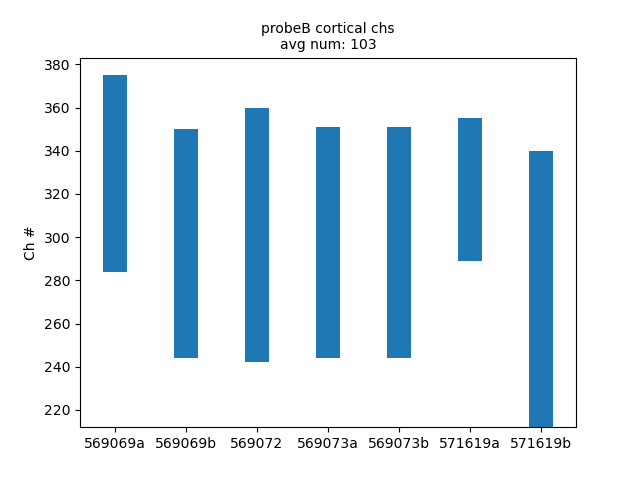

<IPython.core.display.Javascript object>


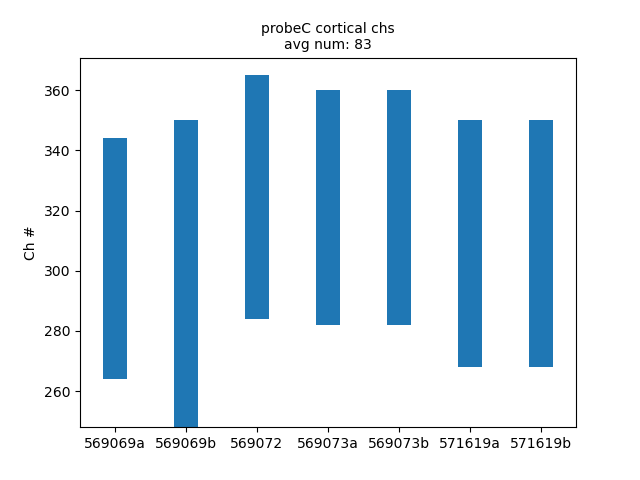

<IPython.core.display.Javascript object>


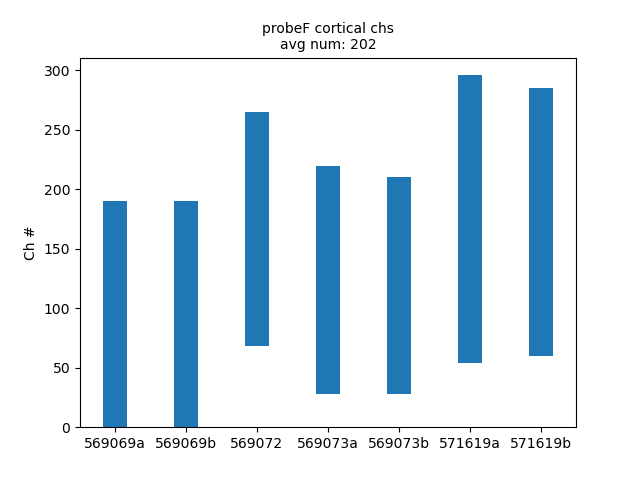

In [14]:
for pl_probe in probe_list:
    mice = []
    surf = []
    bot = []
    num_chs = []
    for mi in sub_ctx_chs.keys():
        mice.append(mi)
        surf.append(sub_ctx_chs[mi][pl_probe]['top'])
        bot.append(sub_ctx_chs[mi][pl_probe]['bottom'])
        num_chs.append(sub_ctx_chs[mi][pl_probe]['top']-sub_ctx_chs[mi][pl_probe]['bottom'])

    fig, ax = plt.subplots()
    ax.bar(mice, num_chs, 0.35, bottom=bot)
    ax.set_ylabel('Ch #')
    ax.set_title('{} cortical chs\navg num: {:d}'.format(pl_probe, int(np.mean(num_chs))))